In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

### Dataset reading and annotations

In [3]:
dataset = pd.read_csv('../Data/Bhaav-Dataset.csv')

In [4]:
dataset

,Sentences,Annotation
0,रमजान के पूरे तीस रोजों के बाद ईद आयी है,1
1,"कितना मनोहर, कितना सुहावना प्रभाव है",1
2,"वृक्षों पर अजीब हरियाली है, खेतों में कुछ अजीब...",1
3,"आज का सूर्य देखो, कितना प्यारा, कितना शीतल है,...",1
4,गाँव में कितनी हलचल है,1
...,...,...
20299,फिर यहाँ सर्दी हो जाती है,4
20300,दिन-भर मैं यह देखती रहती हूँ कि धूप का टुकड़ा क...,4
20301,"पार्क का कोई ऐसा कोना नहीं, जहाँ मैं घड़ी-आधा घ...",4
20302,लेकिन यह बेंच मुझे सबसे अच्छी लगती है,1


In [5]:
dataset['Annotation'].value_counts()

4    11697
2     3168
1     2463
3     1512
0     1464
Name: Annotation, dtype: int64

In [6]:
dataset['Emotion'] = np.where(
    dataset['Annotation'] == 0, 'Anger', np.where(
        dataset['Annotation'] == 1, 'Joy', np.where(
            dataset['Annotation'] == 2, 'Sad', np.where(
                dataset['Annotation'] == 3, 'Suspense', 'Neutral'))))

In [7]:
dataset['Emotion'].value_counts()

Neutral     11697
Sad          3168
Joy          2463
Suspense     1512
Anger        1464
Name: Emotion, dtype: int64

### Convert to TF Dataset and Train/Test Split

In [8]:
full_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(dataset['Sentences'].values, tf.string),
            tf.cast(dataset['Annotation'].values, tf.int32)
        )
    )
)

2022-04-28 19:24:34.292201: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
train_size = int(dataset.shape[0]*0.9)

In [10]:
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)

In [11]:
batch_size = 16

In [12]:
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

### Preprocessing
* Tokenisation
* Punctuation Removal
* Embed words to ints

In [13]:
max_features = 10000
sequence_length = 100

vectorize_layer = layers.TextVectorization(
    standardize="strip_punctuation",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [14]:
train_text = train_dataset.map(lambda x, y: x)

In [15]:
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
text_batch, label_batch = next(iter(train_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'\xe0\xa4\xb0\xe0\xa4\xae\xe0\xa4\x9c\xe0\xa4\xbe\xe0\xa4\xa8 \xe0\xa4\x95\xe0\xa5\x87 \xe0\xa4\xaa\xe0\xa5\x82\xe0\xa4\xb0\xe0\xa5\x87 \xe0\xa4\xa4\xe0\xa5\x80\xe0\xa4\xb8 \xe0\xa4\xb0\xe0\xa5\x8b\xe0\xa4\x9c\xe0\xa5\x8b\xe0\xa4\x82 \xe0\xa4\x95\xe0\xa5\x87 \xe0\xa4\xac\xe0\xa4\xbe\xe0\xa4\xa6 \xe0\xa4\x88\xe0\xa4\xa6 \xe0\xa4\x86\xe0\xa4\xaf\xe0\xa5\x80 \xe0\xa4\xb9\xe0\xa5\x88', shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int32)
Vectorized review (<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[   1,    2,  811, 3149,    1,    2,   74, 2473,  351,    7,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 

In [18]:
train_ds = train_dataset.map(vectorize_text)
val_ds = test_dataset.map(vectorize_text)

In [19]:
embedding_dim = 64

### Model definition

In [20]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(5, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 640,389
Trainable params: 640,389
Non-trainable params: 0
__________________________________________________

In [21]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [22]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
1143/1143 [==============================] - 4s 4ms/step - loss: 1.2454 - sparse_categorical_accuracy: 0.5724 - val_loss: 1.2212 - val_sparse_categorical_accuracy: 0.5938
Epoch 2/10
1143/1143 [==============================] - 4s 4ms/step - loss: 1.2304 - sparse_categorical_accuracy: 0.5741 - val_loss: 1.2133 - val_sparse_categorical_accuracy: 0.5938
Epoch 3/10
1143/1143 [==============================] - 4s 3ms/step - loss: 1.2170 - sparse_categorical_accuracy: 0.5740 - val_loss: 1.2023 - val_sparse_categorical_accuracy: 0.5938
Epoch 4/10
1143/1143 [==============================] - 4s 4ms/step - loss: 1.1998 - sparse_categorical_accuracy: 0.5739 - val_loss: 1.1884 - val_sparse_categorical_accuracy: 0.5938
Epoch 5/10
1143/1143 [==============================] - 5s 4ms/step - loss: 1.1780 - sparse_categorical_accuracy: 0.5742 - val_loss: 1.1719 - val_sparse_categorical_accuracy: 0.5938
Epoch 6/10
1143/1143 [==============================] - 5s 4ms/step - loss: 1.1501 - spars

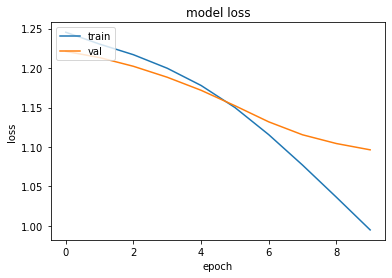

In [23]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
val_softmax = model.predict(val_ds)

In [25]:
val_labels = np.argmax(val_softmax, axis=1)

In [26]:
val_pd = dataset[train_size:]

In [27]:
val_pd['pred_labels'] = val_labels

/var/folders/t_/jx0zym4j5mgf__cxw2drjvwm0000gn/T/ipykernel_56966/905541298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_pd['pred_labels'] = val_labels


In [28]:
val_pd

,Sentences,Annotation,Emotion,pred_labels
18273,भारत की जनता के लिए यह दुर्भाग्य ही रहा कि ताश...,2,Sad,4
18274,11 जनवरी सन्‌ 1966 को इस महान पुरुष का ताशकंद ...,2,Sad,4
18275,मरणोपरांत सन्‌ 1966 में उन्हें भारत के सर्वोच्...,1,Joy,4
18276,राष्ट्र के विजयी प्रधानमंत्री होने के नाते उनक...,4,Neutral,4
18277,सरदार वल्लभभाई पटेल का जन्म 31 अक्टूबर 1875 को...,4,Neutral,4
...,...,...,...,...
20299,फिर यहाँ सर्दी हो जाती है,4,Neutral,4
20300,दिन-भर मैं यह देखती रहती हूँ कि धूप का टुकड़ा क...,4,Neutral,4
20301,"पार्क का कोई ऐसा कोना नहीं, जहाँ मैं घड़ी-आधा घ...",4,Neutral,4
20302,लेकिन यह बेंच मुझे सबसे अच्छी लगती है,1,Joy,4


In [29]:
val_pd['pred_labels'].value_counts()

4    1885
2     132
1      11
0       2
3       1
Name: pred_labels, dtype: int64

In [30]:
val_pd['Annotation'].value_counts()

4    1206
2     403
1     229
3     100
0      93
Name: Annotation, dtype: int64

In [31]:
from sklearn.metrics import classification_report

In [33]:
print (classification_report(val_pd['Annotation'], val_pd['pred_labels']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.82      0.04      0.07       229
           2       0.36      0.12      0.18       403
           3       1.00      0.01      0.02       100
           4       0.61      0.95      0.74      1206

    accuracy                           0.59      2031
   macro avg       0.56      0.22      0.20      2031
weighted avg       0.57      0.59      0.49      2031



### LSTM

In [60]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim, mask_zero=True),
    layers.LSTM(4),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [61]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [62]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
1143/1143 [==============================] - 46s 37ms/step - loss: 1.2439 - sparse_categorical_accuracy: 0.5731 - val_loss: 1.1911 - val_sparse_categorical_accuracy: 0.5938
Epoch 2/10
1143/1143 [==============================] - 42s 37ms/step - loss: 1.1376 - sparse_categorical_accuracy: 0.5848 - val_loss: 1.1600 - val_sparse_categorical_accuracy: 0.5938
Epoch 3/10
1143/1143 [==============================] - 51s 44ms/step - loss: 1.0255 - sparse_categorical_accuracy: 0.6260 - val_loss: 1.2116 - val_sparse_categorical_accuracy: 0.5711
Epoch 4/10
1143/1143 [==============================] - 64s 56ms/step - loss: 0.9257 - sparse_categorical_accuracy: 0.6633 - val_loss: 1.3068 - val_sparse_categorical_accuracy: 0.5628
Epoch 5/10
1143/1143 [==============================] - 75s 65ms/step - loss: 0.8280 - sparse_categorical_accuracy: 0.6975 - val_loss: 1.4143 - val_sparse_categorical_accuracy: 0.5564
Epoch 6/10
1143/1143 [==============================] - 71s 62ms/step - loss: 0.

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
val_softmax = model.predict(val_ds)

In [ ]:
val_labels = np.argmax(val_softmax, axis=1)

In [ ]:
val_pd = dataset[train_size:]

In [ ]:
val_pd['pred_labels'] = val_labels

In [ ]:
val_pd

In [ ]:
val_pd['pred_labels'].value_counts()

In [ ]:
val_pd['Annotation'].value_counts()

In [ ]:
print (classification_report(val_pd['Annotation'], val_pd['pred_labels']))

### Bi-LSTM

In [47]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim, mask_zero=True),
    layers.Bidirectional(tf.keras.layers.LSTM(32)),
    layers.Dense(16, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [35]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
1143/1143 [==============================] - 43s 35ms/step - loss: 1.2396 - sparse_categorical_accuracy: 0.5679 - val_loss: 1.1834 - val_sparse_categorical_accuracy: 0.5938
Epoch 2/10
1143/1143 [==============================] - 42s 37ms/step - loss: 1.1349 - sparse_categorical_accuracy: 0.5803 - val_loss: 1.1508 - val_sparse_categorical_accuracy: 0.5918
Epoch 3/10
 646/1143 [===============>..............] - ETA: 17s - loss: 0.9956 - sparse_categorical_accuracy: 0.6233

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
val_softmax = model.predict(val_ds)

In [ ]:
val_labels = np.argmax(val_softmax, axis=1)

In [ ]:
val_pd = dataset[train_size:]

In [ ]:
val_pd['pred_labels'] = val_labels

In [ ]:
val_pd

In [ ]:
val_pd['pred_labels'].value_counts()

In [ ]:
val_pd['Annotation'].value_counts()

In [33]:
print (classification_report(val_pd['Annotation'], val_pd['pred_labels']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.82      0.04      0.07       229
           2       0.36      0.12      0.18       403
           3       1.00      0.01      0.02       100
           4       0.61      0.95      0.74      1206

    accuracy                           0.59      2031
   macro avg       0.56      0.22      0.20      2031
weighted avg       0.57      0.59      0.49      2031

